In [37]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from scipy.integrate import solve_ivp

In [38]:
def plot_time(system, tstr, init_cond, ax, title):
    result = solve_ivp(system ,tstr, init_cond, method='RK45',
    t_eval=np.linspace(tstr[0], tstr[1], 150))
    ax.plot(result.t, result.y[0], result.t, result.y[1], result.t, result.y[2], result.t, result.y[3])
    ax.legend([r'$x1$', r'$x2$', r'$x3$', r'$x4$'], fontsize=20)
    ax.set_xlabel(r'time (s)')
    ax.set_title(title, fontsize = 15)
    ax.grid()
    return result

In [39]:
def system_anim(result):
    fig, ax = plt.subplots()
    ax.set_xlim((-5, 5))
    ax.set_ylim((-1.5, 1.5))    
    ax.set_aspect('equal')
    ax.grid()

    quad, = ax.plot([],[], marker='s', markersize=40, markeredgecolor='k',markeredgewidth=2)
    line, = ax.plot([], [], 'o-')
    def update(i):
        angle = result.y[2][i]
        axes_car = result.y[0][i]
        quad.set_data([axes_car], [0])
        x1 = np.sin(angle)
        y1 = np.cos(angle)
        line.set_data([axes_car, x1 + axes_car], [0, y1])
        return (line, quad,)
    len(result.y[0])
    fig1 = plt.gcf()
    fig1.set_size_inches(10, 6)
    return animation.FuncAnimation(fig, update, np.arange(1, len(result.y[0])), interval=50, save_count=1000)

In [40]:
def parametrized_pendulum(m, M, g, l, u, th):
    def pendulum(t, x):
        d = (m + M) - m*np.cos(x[2])
        return np.array([
            x[1],
            (m*(g - l*x[3]**2)*np.sin(x[2]) + u(th, x))/d,
            x[3],
            ((g*(m+M)/l - m*x[3]**2)*np.sin(x[2]) + u(th, x)/l)/d
        ])
    return pendulum

def lin_parametrized_pendulum(mu, u_func, th):
    def lin_pendulum(t, x):
        return np.array([
            x[1],
            mu*x[2] + u(th, x),
            x[3],
            (1+mu)*x[2] + u(th, x)
        ])
    return lin_pendulum

def u_control(th, x):
    return np.dot(th, x)

def lin_system_param(A, B, u, th):
    def lin_sys(t, x):
        return np.dot(A, x) + B * u(th, x)
    return lin_sys


In [41]:
def control_matrix(A, B):
    ret = np.array(np.vstack(B))
    ret = np.hstack((ret, np.vstack(np.dot(A, B))))
    #ret = np.hstack((ret, np.vstack(np.dot(np.dot(A, A), B))))
    #ret = np.hstack((ret, np.vstack(np.dot(np.dot(np.dot(A, A), A), B))))
    for i in range(1, A.shape[0] - 1):
        ret = np.hstack((ret, np.vstack(np.dot(A, ret[:,i]))))
    return ret

def Frobenius_first(A, B):
    S1 = control_matrix(A, B)
    print ( "S1 =")
    print(S1)
    rank = np.linalg.matrix_rank(S1)
    if (rank != S1.shape[0]):
        print ("SYSTEM NON-CONTROL, rank = ", rank)
        return None, None, None
    S1_inv = np.linalg.inv(S1)
    return np.dot(np.dot(S1_inv, A), S1), np.dot(S1_inv, B), S1

def Frobenius_second(A, B):
    _A, _B, S1 = Frobenius_first(A, B)
    print("Frobenius first A =")
    print(_A)
    print("B =")
    print(_B)
    _A = np.transpose(_A)
    _B[0] = 0
    _B[_B.shape[0] - 1] = 1
    S2 = control_matrix(_A, _B)
    S2_inv = np.linalg.inv(S2)
    S = np.dot(S1, S2_inv)   
    return _A, _B, S

def find_th(A, B, desired_eigens):
    _A, _B, S = Frobenius_second(A, B)
    print("Frobenius second  A =  ")
    print(_A)
    print("B =  ")
    print(_B)
    desired_poly = np.poly((desired_eigens))
    
    tmp = (_A[_A.shape[0] - 1])[::-1]
    _th = (-tmp - desired_poly[1:])[::-1]
    print(_th)
    S_inv = np.linalg.inv(S)
    return np.dot(_th, S_inv)



In [42]:
mu = 1
l = 0.1
g = 9.8
m = 1
M = 10
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m * g/M, 0],
    [0, 0, 0, 1],
    [0, 0, (M+m) * g / (M*l), 0]
])

B = np.array([0, 1 / M, 0, 1/ (M * l)])
print("A = ")
print(A)
print("eigenv = ", np.linalg.eigvals(A))

A = 
[[  0.     1.     0.     0.  ]
 [  0.     0.     0.98   0.  ]
 [  0.     0.     0.     1.  ]
 [  0.     0.   107.8    0.  ]]
eigenv =  [  0.       0.      10.3827 -10.3827]


S1 =
[[0.000e+00 1.000e-01 0.000e+00 9.800e-01]
 [1.000e-01 0.000e+00 9.800e-01 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 1.078e+02]
 [1.000e+00 0.000e+00 1.078e+02 0.000e+00]]
Frobenius first A =
[[0.0000e+00 1.5578e-14 0.0000e+00 1.6793e-12]
 [1.0000e+00 0.0000e+00 1.5578e-14 0.0000e+00]
 [0.0000e+00 1.0000e+00 0.0000e+00 1.0780e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]
B =
[1. 0. 0. 0.]
Frobenius second  A =  
[[0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00]
 [1.5578e-14 0.0000e+00 1.0000e+00 0.0000e+00]
 [0.0000e+00 1.5578e-14 0.0000e+00 1.0000e+00]
 [1.6793e-12 0.0000e+00 1.0780e+02 0.0000e+00]]
B =  
[0. 0. 0. 1.]
[  -1.    -4.  -113.8   -4. ]
th = [ 1.0204e-01  4.0816e-01 -1.1381e+02 -4.0408e+00]


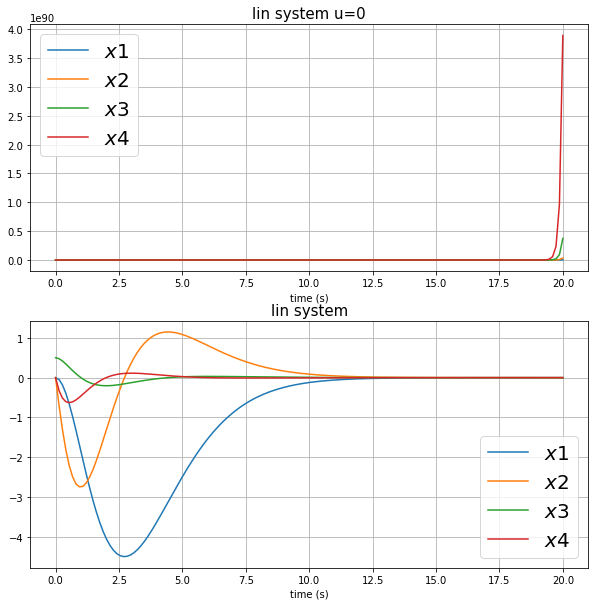

[[ 0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00]
 [ 1.0204e-02  4.0816e-02 -1.0401e+01 -4.0408e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]
 [ 1.0204e-01  4.0816e-01 -6.0102e+00 -4.0408e+00]]
[-1.0006+0.0006j -1.0006-0.0006j -0.9994+0.0006j -0.9994-0.0006j]


In [ ]:
np.set_printoptions(precision=4)
nrow = 2

fig, (ax1, ax2) = plt.subplots(nrows=nrow, figsize=(10,5 * nrow))
t_interval = np.array([0, 20])
init_cond = np.array([0, 0, 0.5, 0])

sys = lin_system_param(A, B, u_control, np.array([0, 0, 0, 0]))

plot_time(sys, t_interval, init_cond,
          ax1, r"lin system u=0")


desired_eigens = np.array([-1 ,-1, -1, -1])
th = find_th(A, B, desired_eigens)
print("th =" , th)
new_sys = lin_system_param(A, B, u_control, th)

res = plot_time(new_sys, t_interval, init_cond,
          ax2, r"lin system")

plt.show()
A1 = np.copy(A)
A1[1] = A1[1] + B[1]*th
A1[3] = A1[3] + B[3]*th
print(A1)
print (np.linalg.eigvals(A1))

plt.show()

anim = system_anim(res)
#video = HTML(anim.to_html5_video())
#mywriter = anim.FFMpegWriter()
anim.save('mymovie.mp4')